# <Center> CSCA 5632: Unsupervised Learning Wk5 Project: <br> <br> Face Recognition using NMF 

Github https:  https://github.com/wayne-ck19/csca_5632.git

## 1. Project Overview 

### 1.1 Introduction

Face recognition is a vital field in computer vision and machine learning with numerous applications in security, authentication, social media, and more. 

The most popular model and first choice for a computer vision problem, such as face recognition, may be CNN (Convolutional Neural Networks) deep learning model. CNNS are highly effective for the facial recognition problem due to their ability to automatically learn spatial hierarchies of features from input images. A CNN consists of multiple layers, including convolutional layers that apply filters to capture features such as edges, textures, and shapes; pooling layers that reduce the spatial dimensions to make the network computationally efficient and robust against variations; and fully connected layers that interpret the features to classify the images. There are many open sourced highly effective CNN based computer vision models.

However, CNNs and deep learning models are out of the scope of this course. In this project, we aim to perform face recognition using an unsupervised learning approach combined with a simple shallow learning method.

### 1.2 Dataset

We utilize the "Olivetti Faces" dataset, a widely recognized benchmark dataset for face recognition tasks. The dataset contains:
- **Number of images:** 400
- **Number of individuals:** 40
- **Images per individual:** 10
- **Image size:** 64x64 pixels
- **Image format:** Grayscale

The images in the dataset capture various facial expressions and configurations, providing a robust basis for testing face recognition algorithms.

### 1.3 Methodology

Each image size is 64 x 64 pixels. If we directly apply a supervised machine learning method, we will first need to flattern the image matrix, resulting in a feature size of $64 \times 64$ \= 4096. Supervised classification methods may suffer from the curse of dimensionality and overfitting issues. Therefore, each image matrix should be projected to a lower-dimensional latent space before applying any supervised learning algorithms.

Our approach involves two main steps: feature extraction and projection of images to a lower-dimensional latent space using Non-negative Matrix Factorization (NMF) and classification using a simple kNN model. 


#### I. Feature Extraction and Lower-dimensional Projection with NMF

The unsupervised learning method: Non-negative Matrix Factorization (NMF), is used to decompose the original data matrix \( V \) into two matrices:
$[ V \approx W \cdot H ]$
where:
- \( V \) is the original data matrix (face images).
- \( W \) is the latent feature matrix (basis components).
- \( H \) is the coefficient matrix.

NMF ensures that the matrices \( W \) and \( H \) have no negative elements, making the features more interpretable. The matrix \( W \) contains the latent features that represent the essential aspects of the face images.

#### II. NMF Label Mapping using kNN

Since NMF is an unsupervised learning method, it does not directly utilize label information during the decomposition and does not provide a way to associate latent features with face labels. Label permuation, that works well for BBC News Topic Classfication, is impractical (<font color = 'red'> $ 8.1 \times 10^{47} $ permuatations </font>) in our project.  To bridge this gap, we use kNN to map NMF decomposition to face labels:

1. **Training**: Train the knn model using the \( W \) matrix (latent features) and the known face labels.
2. **Prediction**: Use the trained knn model to predict the face labels of new images based on their positions in the latent feature space.

knn helps in accurately mapping the latent features to the correct labels by considering the nearest neighbors and using a majority voting mechanism. This step is essential to ensure that the unsupervised features extracted by NMF are correctly associated with the provided face labels.



## 2. EDA
### 2.1 Dataset Source and Introduction

We will use the "Olivetti Faces" dataset, also known as "Olivetti Research Laboratory (ORL) Database of Faces". This is a standard dataset used for evaluating face recognition algorithms. The dataset was created between 1992 and 1994 at AT&T Laboratories in Cambridge, U.K. It is widely used in the machine learning and computer vision communities as a benchmark for various face recognition algorithms.

The details of the dataset are given below:

- **Number of images:** 400
- **Number of individuals:** 40
- **Images per individual:** 10
- **Image size:** 64x64 pixels
- **Image format:** Grayscale

Each image represents a different facial expression (happy, sad, angry, etc.) or a different configuration of facial features (open/closed eyes, smiling/not smiling, etc.).

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import math

### 2.2 Dataset Loading and EDA (Normalizing, Visualization)

In [59]:
data = fetch_olivetti_faces(shuffle=True)
img = data.images  # (400, 64, 64)
label = data.target  # (400,)

In [60]:
print(f'Sample size is {img.shape[0]}')
print(f'Image Pixels = {img.shape[1]} X {img.shape[1]}')

Sample size is 400
Image Pixels = 64 X 64


<BarContainer object of 40 artists>

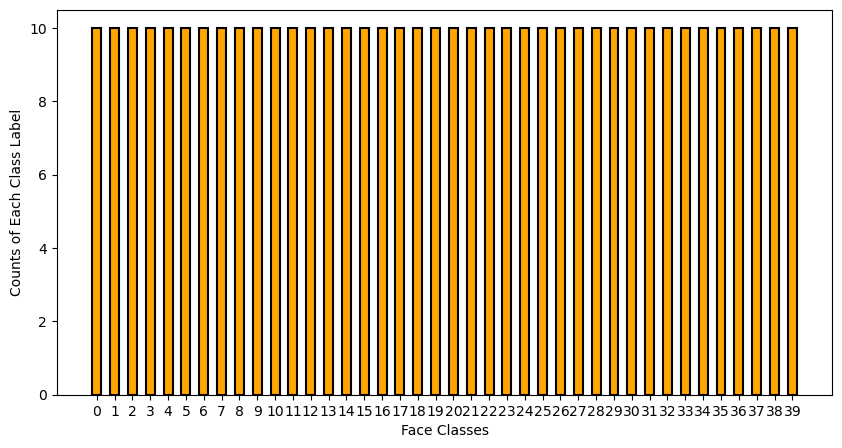

In [61]:
class_counts = np.unique(label, return_counts = True)
fig = plt.figure(figsize=(10,5))

plt.xticks(ticks=range(len(class_counts[1])), labels=class_counts[0])
plt.xlabel('Face Classes')
plt.ylabel('Counts of Each Class Label')
plt.bar(class_counts[0],class_counts[1], width=0.5, edgecolor='black', linewidth=1.5, facecolor='orange')

#### 2.2.1 Dataset Label Classes and Data Balance

The dataset has 40 different face classes, and each class has exactly 10 counts. It is perfectly balanced data set and great for a course project like this

#### 2.2.2 Visualization of Images
##### <font color = 'blue'> Let's display some images, and see what we got

In [91]:
def image_plot(img_sample, n):    
    ncol = 10
    nrow = math.ceil(n/ncol)    
    fig, axe = plt.subplots(nrow, ncol, figsize = (14,4))
    for i, ax in enumerate(axe.flat):
        ax.imshow(img_sample[i,:,:], cmap = 'grey')
        ax.axis('off')

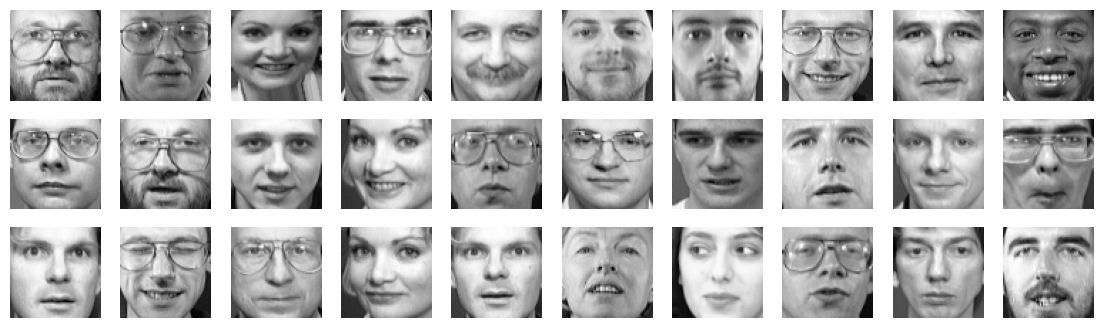

In [62]:
image_plot(img, 30)

#### 2.2.3 Data Normalizing and Visualization

Normalize the image matrix values to (0,1) range for the later NMF and kNN models

In [63]:
img_norm = np.zeros_like(img, dtype = float)
for i in range(img_norm.shape[0]):
    img_norm[i] = img[i] / img[i].max()

##### <font color = 'blue'> Let's display some images of normalzied matrix, and see if they work as original images

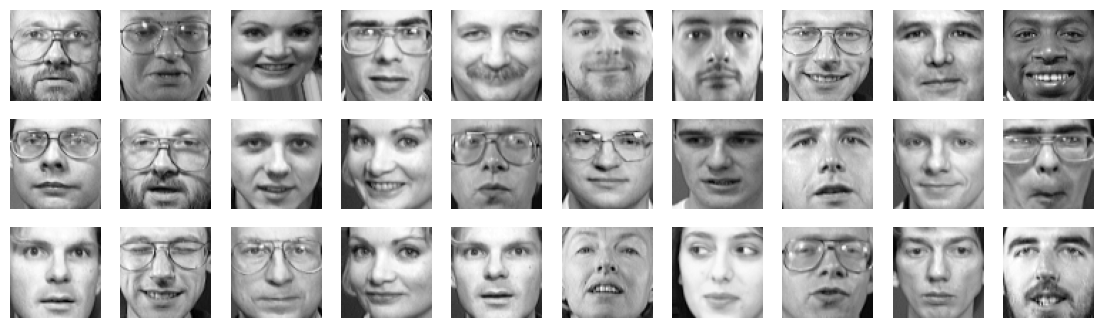

In [64]:
image_plot(img_norm, 30)

##### <font color = 'blue'> They look good. Let's move to train and test split, and then we build a pipeline for training

#### 2.2.4 Split Data into Training and Testing Sets

In [98]:
X_train, X_test, y_train, y_test = train_test_split(img_norm, label, test_size = 0.2, random_state = 31, stratify=label)

## 3. Model Training and Parametric Grid Search
### 3.1 Build Model Pipeline

We build a pipeline to simplify the GridSearchCV in a later step.

Pipeline consists of:
- Flatten each 64 x 64 image to 1D, making the input matrix 2D as NMF only recognize 2D matrix input
- <font color = 'blue'> NMF model for image latent feature extraction (critical step of the model)
- kNN model on W matrix of NMF ouput

In [122]:
nmf_pipeline = Pipeline(steps = [
    ('flatten', FunctionTransformer(lambda x:x.reshape((len(x),-1)))),
    ('nmfModel', NMF(n_components = 30, init = 'nndsvda', solver = 'mu', random_state = 40, max_iter = 3000)), # NMF for feature extraction
    ('knn', KNeighborsClassifier(n_neighbors = 5)) # knn to map NMF score to target labels
])

### 3.2 Grid Search CV to find the best estimator



In [123]:
# define the param_grid
param_grid = {
    'nmfModel__n_components': [20, 30, 40, 50],  # Number of latent features to extract
    'nmfModel__init': ['random', 'nndsvda'],  # NMF initialization method
    'nmfModel__beta_loss': ['frobenius', 'kullback-leibler'],  # NMF beta loss method
    'knn__n_neighbors': [5, 10]  # knn mapping step: neighbor number (this is not a critical step, so we don't focus on parameters in this step 
}

In [124]:
grid_search = GridSearchCV(estimator=nmf_pipeline, param_grid=param_grid, scoring='f1_macro', cv=5, verbose = 2, n_jobs=-1)

### 3.3 Grid Search Training

In [125]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('flatten',
                                        FunctionTransformer(func=<function <lambda> at 0x00000203D9CFC0E0>)),
                                       ('nmfModel',
                                        NMF(init='nndsvda', max_iter=3000,
                                            n_components=30, random_state=40,
                                            solver='mu')),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [5, 10],
                         'nmfModel__beta_loss': ['frobenius',
                                                 'kullback-leibler'],
                         'nmfModel__init': ['random', 'nndsvda'],
                         'nmfModel__n_components': [20, 30, 40, 50]},
             scoring='f1_macro', verbose=2)

### 3.3 Grid Search Results

##### <font color = 'blue'> Let's take a look what are the features in the image are extracted? 

Text(0.5, 0, 'Features Extracted from Image')

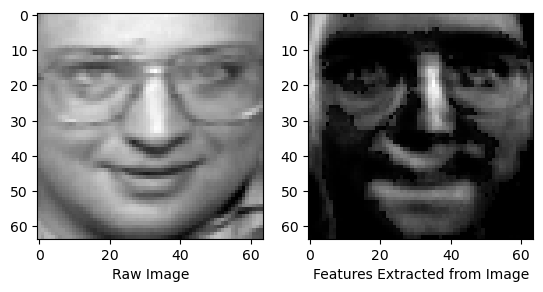

In [211]:
best_pipe = grid_search.best_estimator_
H_matrix = best_pipe.named_steps['nmfModel'].components_
i = 8 # just pick an image and see what is going on
feature_img = H_matrix[i,:].reshape((64,64))
raw_img = X_train[5]
fig1, axe1 = plt.subplots(1,2)
axe1.flat[0].imshow(raw_img,cmap='grey')
axe1.flat[0].set_xlabel('Raw Image')
axe1.flat[1].imshow(feature_img, cmap='grey') 
axe1.flat[1].set_xlabel('Features Extracted from Image')
## Please note: the H_martrix is fixed after model training. The feature sequence does not align with training image sequence. 
## The raw image and feature image we show here may not come from the same face

##### <font color = 'blue'> From the images above, we can see the NMF essentially applies different filters to the images and extract different features (e.g. light, texture, shape,...) on each image. <br> <br> Below are the parameteric study results

In [126]:
grid_search.best_params_

{'knn__n_neighbors': 5,
 'nmfModel__beta_loss': 'frobenius',
 'nmfModel__init': 'nndsvda',
 'nmfModel__n_components': 40}

In [166]:
grid_results = pd.DataFrame(grid_search.cv_results_).loc[:,['param_knn__n_neighbors','param_nmfModel__beta_loss','param_nmfModel__init',
                                                             'param_nmfModel__n_components','mean_test_score']]

group_list = []
for i, group in grid_results.groupby(by=['param_knn__n_neighbors','param_nmfModel__beta_loss','param_nmfModel__init']):
    group_list.append((i,group))

In [164]:
def plot_para_result(para_group):
    fig = plt.figure(figsize = (10,6))
    for i in range(len(para_group)):
        x = para_group[i][1].iloc[:,-2]
        y = para_group[i][1].iloc[:,-1]
        info = para_group[i][0]
        label = '+'.join([f'nb_{info[0]}', info[1], info[2]])
        if info[0] == 5:
            plt.plot(x, y, linestyle = '-', label = label)
        else:
            plt.plot(x, y, linestyle = '--', label = label)
    plt.legend(fontsize='small', loc=0)
    plt.xlabel('NMF Feature Extraction Components')
    plt.ylabel('Mean Validation Data F1 Score')

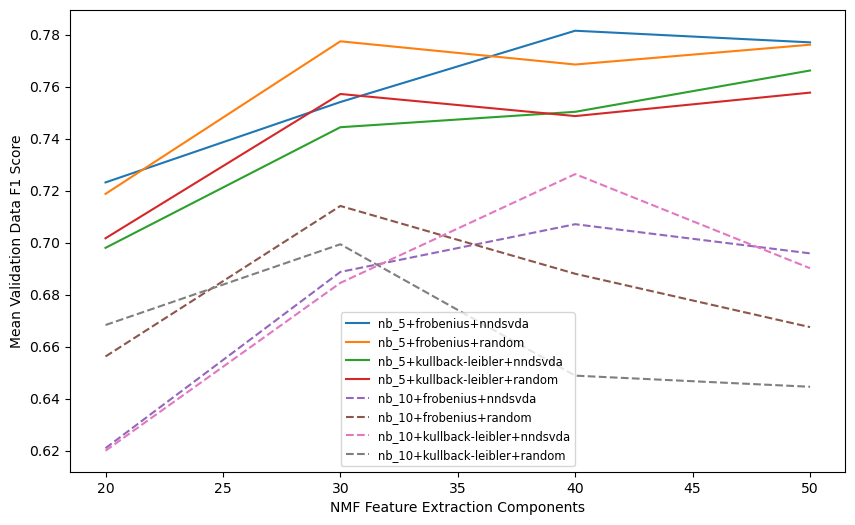

In [165]:
plot_para_result(group_list)

#### 3.3.1 Grid Search Results Discussion

The unsupervised learning NMF plays the key role extracting latent features from the images. The above figure shows the impacts of all studied parameters on the average F1 Score. Please note this F1 Score is the averaged score of the 5-fold validation data. 

(1) in unsupervised learning NMF, the loss function method Frobenius and Kullback-leibler have shown the impacts on the F1 score. Frobenius generally has the better solution. <br>
(2) in underpervised learning NMF, the key parameter that has significant impact on the result is the number of components for feature extraction (n_components). For this image face classification problem, the feature number must be at least larger than 30 to achieve acceptable F1 Score <br>
(3) the knn that maps the extracted feature matrix to target labels, performs well for the default neighbor number (5). Higher neighbor numer deteriates the mapping results.

## 4. Test Results
### 4.1 Model on Test Data

In [228]:
ypred = grid_search.best_estimator_.predict(X_test)
f1score = f1_score(y_test, ypred, average = 'macro')
accscore = accuracy_score(y_test, ypred)
print(f'The F1 Score on Test Data is {f1score:.2f}')
print(f'The Accuracy Score on Test Data is {accscore:.2f}')

The F1 Score on Test Data is 0.85
The Accuracy Score on Test Data is 0.86


### 4.2 Conclusion

By leveraging NMF to identify meaningful features and employing knn for label mapping, we aim to develop a robust face recognition system. This approach highlights the integration of unsupervised learning for feature extraction followed by supervised learning for label prediction, showcasing the strengths and applications of both techniques in image pattern recognition.

